In [848]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d

# Online Retail Data

In this notebook, we will take a look at the dataset of an online retailer and calculate some high level statistic to provide some insights on the sales data. Thereafter, we will look into the problem of segmenting the customers.

Segmenting customers allows a company to be surgical in terms of their promotions/actions towards different groups of customers.

## Import Data

In [466]:
data_pdf = pd.read_excel("online_retail.xlsx", 
                         names=["invoice_no", "stock_code", "description", "quantity", "invoice_date", "unit_price",
                               "customer_id", "country"] )

The `online_retail` is an open source dataset by UCI. It is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Field details:

1. invoice_no: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
1. stock_code: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
1. description: Product (item) name. Nominal. 
1. quantity: The quantities of each product (item) per transaction. Numeric. 
1. invoice_date: Invice Date and time. Numeric, the day and time when each transaction was generated. 
1. unit_price: Unit price. Numeric, Product price per unit in sterling. 
1. customer_id: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
1. country: Country name. Nominal, the name of the country where each customer resides.

## Data Summary

In [1075]:
# Shape of data
print(f"Data: {data_pdf.shape}")

Data: (541909, 8)


In [1076]:
data_pdf.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [1077]:
# Summary of data
data_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  float64       
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Note: `description` and `customer_id` contain null values. Also, `customer_id` makes more sense to be a string (object) type.

In [1078]:
# Finding the % of null values
def display_missing(df):
  for col in df.columns.tolist():
    null_rows = df[col].isnull().sum()
    total_rows = len(df)
    print(f'{col} column missing values: {null_rows}, ({((null_rows/total_rows)*100):.2f}%)')
  print('\n')

display_missing(data_pdf)

invoice_no column missing values: 0, (0.00%)
stock_code column missing values: 0, (0.00%)
description column missing values: 1454, (0.27%)
quantity column missing values: 0, (0.00%)
invoice_date column missing values: 0, (0.00%)
unit_price column missing values: 0, (0.00%)
customer_id column missing values: 135080, (24.93%)
country column missing values: 0, (0.00%)




Note: 25% of the data does not have `customer_id`. As we will be attempting to segment the customers which requires information such as frequency of purchases of the customer, having a null `customer_id` would not be useful. Hence, we would have to drop such rows before we attempt to segment the customers.

In [1079]:
# Summary statistics of data
data_pdf.describe()

,quantity,unit_price,customer_id
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Note: `quantity` and `unit_price` contain negative values which do not make sense.

In [1080]:
# Find % negative/0 of quantity values
neg_0_quantity_pdf = data_pdf.copy()
neg_0_quantity_pdf = neg_0_quantity_pdf[neg_0_quantity_pdf["quantity"]<=0]
print(f"quantity column negative/0 values: {len(neg_0_quantity_pdf)}, ({(len(neg_0_quantity_pdf)/541909):.2f}%)")

quantity column negative/0 values: 10624, (0.02%)


In [1081]:
neg_0_quantity_pdf.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [1082]:
neg_0_quantity_pdf["invoice_type"] = neg_0_quantity_pdf["invoice_no"].map(lambda cell: str(cell)[0])
neg_0_quantity_pdf["invoice_type"].value_counts()

C    9288
5    1336
Name: invoice_type, dtype: int64

Note: The % of negative/0 `quantity` values are low. Removing those rows would thus have minimal impact. Furthermore, the majority of negative/0 `quantity` values belong to cancelled orders.

In [1083]:
# Find % of negative/0 unit_price values
neg_0_unitprice_pdf = data_pdf.copy()
neg_0_unitprice_pdf = neg_0_unitprice_pdf[neg_0_unitprice_pdf["unit_price"]<=0]
print(f"unit_price column negative/0 values: {len(neg_0_unitprice_pdf)}, ({(len(neg_0_unitprice_pdf)/541909):.3f}%)")

unit_price column negative/0 values: 2517, (0.005%)


In [1084]:
neg_0_unitprice_pdf.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


In [1085]:
neg_0_unitprice_pdf["customer_id"].isnull().sum()

2477

Note: The % of negative/0 `unit_price` values are low as well. Removing those rows would thus have minimal impact. Furthermore, majority of the rows also have a null `customer_id`.

## Data Cleaning

In [1086]:
# Drop rows with null customer_id
data_clean_pdf = data_pdf.copy()
data_clean_pdf = data_clean_pdf[~data_clean_pdf["customer_id"].isnull()]
data_clean_pdf.shape

(406829, 8)

In [1087]:
# Drop rows with negative quantity and negative unit_price
data_clean_pdf = data_clean_pdf[(data_clean_pdf["quantity"]>0) & (data_clean_pdf["unit_price"]>0)]
data_clean_pdf.shape

(397884, 8)

In [1088]:
# Convert customer_id to an object type
data_clean_pdf = data_clean_pdf.astype({"customer_id": int})
data_clean_pdf = data_clean_pdf.astype({"customer_id": str})
data_clean_pdf["customer_id"] = data_clean_pdf["customer_id"].map(lambda cell: cell.strip())

In [1089]:
data_clean_pdf.reset_index(inplace=True)

In [1090]:
data_clean_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   index         397884 non-null  int64         
 1   invoice_no    397884 non-null  object        
 2   stock_code    397884 non-null  object        
 3   description   397884 non-null  object        
 4   quantity      397884 non-null  int64         
 5   invoice_date  397884 non-null  datetime64[ns]
 6   unit_price    397884 non-null  float64       
 7   customer_id   397884 non-null  object        
 8   country       397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 27.3+ MB


# Exploratory Data Analysis

In [1091]:
# Make invoice_date the index
data_clean_pdf.index = data_clean_pdf["invoice_date"]
data_clean_pdf.drop(columns=["index"], inplace=True)
data_clean_pdf

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
invoice_date,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
2011-12-09 12:50:00,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
2011-12-09 12:50:00,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France


## Create `revenue` field

In [1092]:
# Create a revenue field from quantity and unit_price
data_clean_pdf["revenue"] = data_clean_pdf["quantity"] * data_clean_pdf["unit_price"]

In [1093]:
data_clean_pdf["revenue"].describe()

count    397884.000000
mean         22.397000
std         309.071041
min           0.001000
25%           4.680000
50%          11.800000
75%          19.800000
max      168469.600000
Name: revenue, dtype: float64

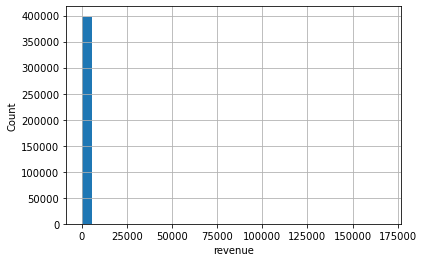

In [1094]:
# Plot a histogram for revenue
data_clean_pdf["revenue"].hist(bins=30)
plt.xlabel("revenue")
plt.ylabel('Count')
plt.show()

Note: `revenue` has a right-skewed distribution. We will perform a log transformation on it to make it closer to a normal distribution.

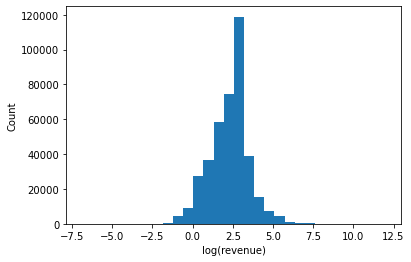

In [1095]:
# Plot a histogram for the log transformed quantity
data_clean_pdf["log_revenue"] = np.log(data_clean_pdf["revenue"])
plt.hist(data_clean_pdf["log_revenue"], bins=30)
plt.xlabel('log(revenue)')
plt.ylabel('Count')
plt.show()

## `quantity`

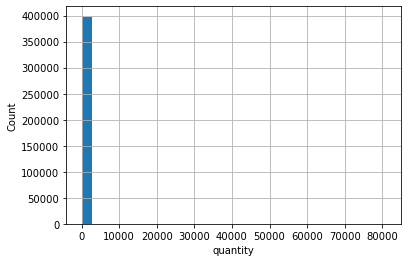

In [1096]:
# Plot a histogram for quantity
data_clean_pdf["quantity"].hist(bins=30)
plt.xlabel("quantity")
plt.ylabel('Count')
plt.show()

Note: `quantity` has a right-skewed distribution. We will perform a log transformation on it to make it closer to a normal distribution.

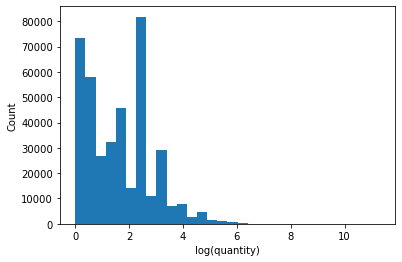

In [1097]:
# Plot a histogram for the log transformed quantity
data_clean_pdf["log_quantity"] = np.log(data_clean_pdf["quantity"])
plt.hist(data_clean_pdf["log_quantity"], bins=30)
plt.xlabel('log(quantity)')
plt.ylabel('Count')
plt.show()

## `unit_price`

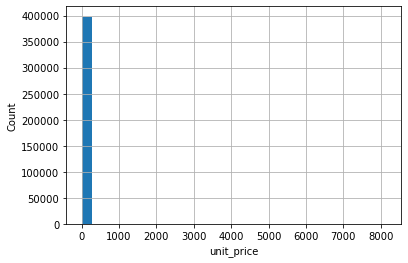

In [1098]:
# Plot a histogram for unit_price
data_clean_pdf["unit_price"].hist(bins=30)
plt.xlabel("unit_price")
plt.ylabel('Count')
plt.show()

Note: `unit_price` also has a right-skewed distribution. We will perform a log transformation on it to make it closer to a normal distribution.

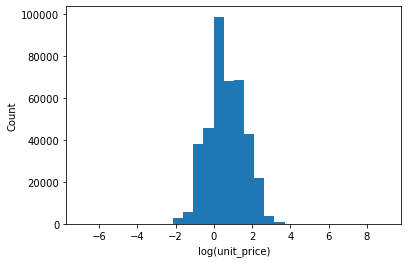

In [1099]:
# Plot a histogram for the log transformed quantity
data_clean_pdf["log_unit_price"] = np.log(data_clean_pdf["unit_price"])
plt.hist(data_clean_pdf["log_unit_price"], bins=30)
plt.xlabel('log(unit_price)')
plt.ylabel('Count')
plt.show()

## Cleaned data

In [1100]:
data_clean_pdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397884 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   invoice_no      397884 non-null  object        
 1   stock_code      397884 non-null  object        
 2   description     397884 non-null  object        
 3   quantity        397884 non-null  int64         
 4   invoice_date    397884 non-null  datetime64[ns]
 5   unit_price      397884 non-null  float64       
 6   customer_id     397884 non-null  object        
 7   country         397884 non-null  object        
 8   revenue         397884 non-null  float64       
 9   log_revenue     397884 non-null  float64       
 10  log_quantity    397884 non-null  float64       
 11  log_unit_price  397884 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(5)
memory usage: 39.5+ MB


In [1101]:
# Number of unique values for each field
data_clean_pdf.nunique().sort_values()

country              37
quantity            301
log_quantity        301
unit_price          440
log_unit_price      440
log_revenue        2785
revenue            2939
stock_code         3665
description        3877
customer_id        4338
invoice_date      17282
invoice_no        18532
dtype: int64

## Insights

### Mean revenue by country

In [1104]:
top_products_by_country = data_clean_pdf["country"].value_counts().sort_values(ascending=False)
top_products_by_country.head(15)

United Kingdom     354321
Germany              9040
France               8341
EIRE                 7236
Spain                2484
Netherlands          2359
Belgium              2031
Switzerland          1841
Portugal             1462
Australia            1182
Norway               1071
Italy                 758
Channel Islands       748
Finland               685
Cyprus                614
Name: country, dtype: int64

Note: As most data points originate from the United Kingdom, finding out which country contributes the most by using a cumulative revenue might not be accurate. We will instead find out the mean revenue contribution by each country.

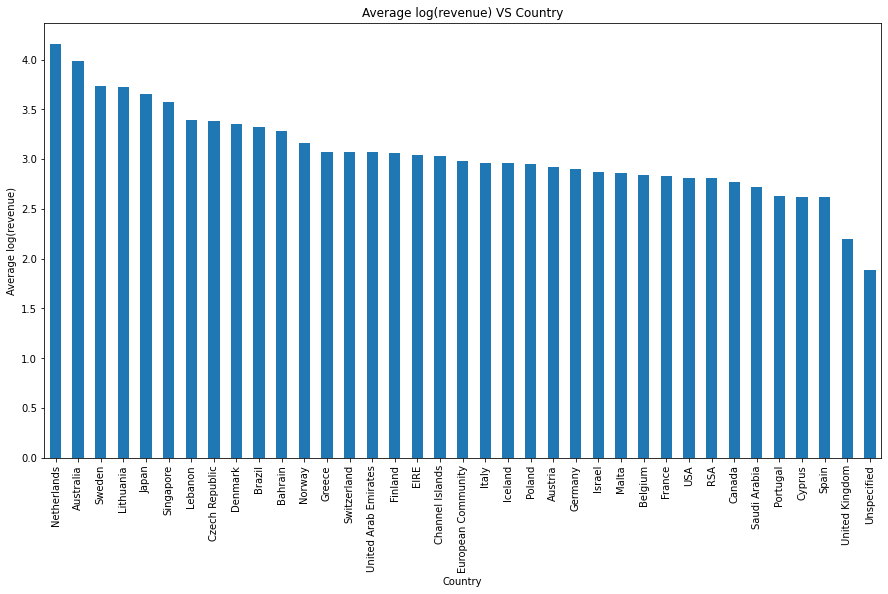

In [1105]:
data_clean_pdf.groupby("country").log_revenue.mean().sort_values(ascending=False).plot(kind='bar', figsize=(15,8))
plt.xlabel("Country")
plt.ylabel("Average log(revenue)")
plt.title("Average log(revenue) VS Country")
plt.show()

Observation: The top 5 countries that contribute the highest mean revenue are - Netherlands, Australia, Sweden, Lithuania and Japan.

Note: EIRE = Ireland. Also, there are `unspecified` countries that could affect the results of this observation, but it is okay to retain them unless their impact is huge.

### Sales quantity/revenue across time

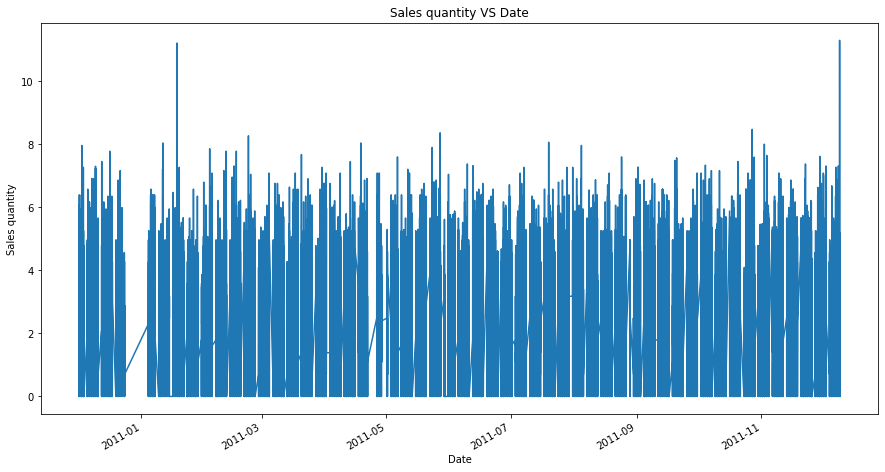

In [1106]:
# Plot a graph of quantity against time
data_clean_pdf['log_quantity'].plot(figsize=(15,8))
plt.xlabel("Date")
plt.ylabel("Sales quantity")
plt.title("Sales quantity VS Date")
plt.show()

Note: The graph is hard to understand due to the repetitive time stamps in the data and the granularity of the timescale. As such, we will resample the data by month i.e. we will aggregate all the data points by month and plot the graph again.

In [1107]:
# Resample the dataset by month
monthly_resampled_pdf = data_clean_pdf[["log_quantity", "log_revenue"]].resample('M').sum()
monthly_resampled_pdf.head(5)

,log_quantity,log_revenue
invoice_date,,
2010-12-31,39914.182000,59270.446507
2011-01-31,35849.821047,50860.160682
2011-02-28,33424.147877,47827.134875
2011-03-31,45206.404722,63479.687670
2011-04-30,37663.303180,52346.118784


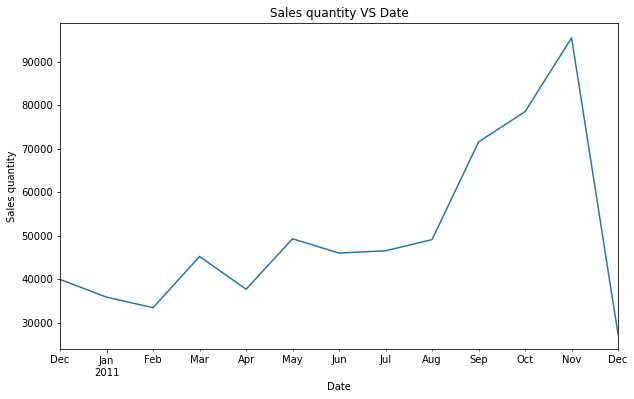

In [1108]:
# Plot a graph of quantity against time
monthly_resampled_pdf['log_quantity'].plot(figsize=(10,6))
plt.xlabel("Date")
plt.ylabel("Sales quantity")
plt.title("Sales quantity VS Date")
plt.show()

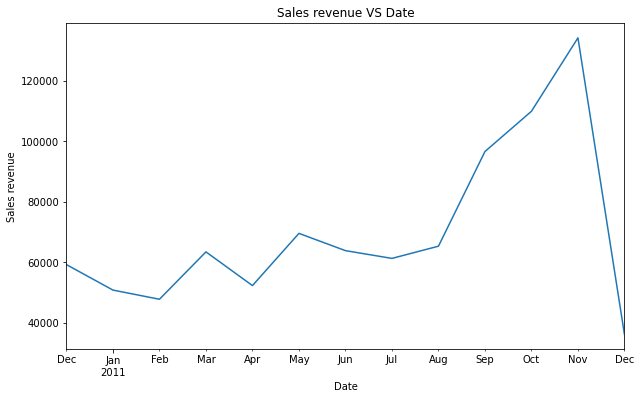

In [1109]:
# Plot a graph of revenue against time
monthly_resampled_pdf['log_revenue'].plot(figsize=(10,6))
plt.xlabel("Date")
plt.ylabel("Sales revenue")
plt.title("Sales revenue VS Date")
plt.show()

Observation: Both graphs are similar as revenue is related to the quantity of items being sold. From the graph, we can see that sales picked up tremendously in the last quarter of 2011. We can ignore the drop in sales in Dec 2011 as it could be due to to lack of data points.

# RFM Analysis (Feature Engineering)

After gaining some insights from the data, the company would have gathered some high level statistics of their operations i.e. which period of the year was sales the highest. To go one step further to increase revenue, we will segment the customers of the company. By segmenting the customers into different groups, the company would better understand their customers and be able to introduce specific campaigns targetted at the different groups.

To segment customers, we will utilise the concept of RFM analysis, which revolves around:

1. R (Recency): How recent was the customer's last purchase?
1. F (Frequency): How often did the customer make a purchase in a given period?
1. M (Monetary): How much money did the customer spend in a given period?

Each customer will be assigned scores based on their ranking in R, F and M. The score range from 1 - 5 and is based on quintiles. The 3 values, together, will determine the group that the customer belongs to.

In [1110]:
rfm_pdf = data_clean_pdf.copy()

## Recency

To calculate how recent a customer has shopped in the store, we would need a reference date. As the last date in the dataset is 2011-12-09, we will set the reference date to be 2012-01-09.

In [1111]:
# Set reference date
ref_date = datetime(2012, 1, 9)

In [1112]:
# Calculate number of days since reference date
rfm_pdf["days_since_ref"] = ref_date - rfm_pdf["invoice_date"]
rfm_pdf["days_since_ref"] = rfm_pdf["days_since_ref"].map(lambda cell: cell.days)
rfm_pdf["days_since_ref"].head(5)

invoice_date
2010-12-01 08:26:00    403
2010-12-01 08:26:00    403
2010-12-01 08:26:00    403
2010-12-01 08:26:00    403
2010-12-01 08:26:00    403
Name: days_since_ref, dtype: int64

In [1113]:
# Calculate recency of a customer by taking the min `days_since_ref` across all its orders
recency = rfm_pdf[["customer_id", "days_since_ref"]].groupby("customer_id").agg({"days_since_ref":"min"})

In [1114]:
recency.rename(columns={'days_since_ref':'Recency'}, inplace=True)

In [1115]:
recency

,Recency
customer_id,
12346,355
12347,32
12348,105
12349,48
12350,340
...,...
18280,307
18281,210
18282,37


## Frequency

In [1116]:
# Count the number of unique invoices per customer_id
freq_check = rfm_pdf.groupby(["customer_id", "invoice_no"]).revenue.sum()

In [1117]:
frequency = freq_check.groupby('customer_id').size().to_frame()
frequency.rename(columns={'revenue':'Frequency'}, inplace=True)

In [1118]:
frequency

,Frequency
customer_id,
12346,1
12347,7
12348,4
12349,1
12350,1
...,...
18280,1
18281,1
18282,2


## Monetary

In [1119]:
# Calculate the total revenue per customer
monetary = rfm_pdf.groupby('customer_id').revenue.sum().to_frame()
monetary.rename(columns={'revenue':'Monetary'}, inplace=True)

In [1120]:
monetary

,Monetary
customer_id,
12346,77183.60
12347,4310.00
12348,1797.24
12349,1757.55
12350,334.40
...,...
18280,180.60
18281,80.82
18282,178.05


## Merge R, F and M into a single DataFrame

In [1121]:
rf = pd.merge(recency, frequency, on="customer_id")
rf.head()

,Recency,Frequency
customer_id,,
12346,355,1
12347,32,7
12348,105,4
12349,48,1
12350,340,1


In [1122]:
rfm = pd.merge(rf, monetary, on="customer_id")
rfm.head()

,Recency,Frequency,Monetary
customer_id,,,
12346,355,1,77183.60
12347,32,7,4310.00
12348,105,4,1797.24
12349,48,1,1757.55
12350,340,1,334.40


## Calculate the RFM score

In [1123]:
rfm_score_pdf = rfm.copy()

Note: The lower the recency value, the higher the recency score because the customer made a purchase much more recently.

In [1124]:
# Recency score
rescore = [5, 4, 3, 2 ,1]
rfm_score_pdf["re_score"] =  pd.qcut(rfm_score_pdf["Recency"], q=5, labels=rscore)

Note: The higher the frequency value, the higher the frequency score because the customer made more frequent purchases.

In [1125]:
# Frequency score
# qcut does not work with fields with frequently repeated values; the solution is to rank the field first
freqscore = [1, 2, 3, 4, 5]
rfm_score_pdf["Frequency"] = rfm_score_pdf["Frequency"].rank(method="first")
rfm_score_pdf["freq_score"] = pd.qcut(rfm_score_pdf["Frequency"], q=5, labels=freqscore)

Note: The higher the monetary value, the higher the monetary score because the customer are spent more.

In [1126]:
# Monetary score
monscore = [1, 2, 3, 4, 5]
rfm_score_pdf["mon_score"] = pd.qcut(rfm_score_pdf["Monetary"], q=5, labels=monscore)

In [1127]:
rfm_score_pdf.head()

,Recency,Frequency,Monetary,re_score,freq_score,mon_score
customer_id,,,,,,
12346,355,1.0,77183.60,1,1,5
12347,32,3639.0,4310.00,5,5,5
12348,105,2837.0,1797.24,2,4,4
12349,48,2.0,1757.55,4,1,4
12350,340,3.0,334.40,1,1,2


In [1128]:
rfm_score_pdf["RFM"] = rfm_score_pdf.re_score.astype(str) + rfm_score_pdf.freq_score.astype(str) + rfm_score_pdf.mon_score.astype(str)

In [1129]:
rfm_score_pdf.head(10)

,Recency,Frequency,Monetary,re_score,freq_score,mon_score,RFM
customer_id,,,,,,,
12346,355,1.0,77183.60,1,1,5,115
12347,32,3639.0,4310.00,5,5,5,555
12348,105,2837.0,1797.24,2,4,4,244
12349,48,2.0,1757.55,4,1,4,414
12350,340,3.0,334.40,1,1,2,112
12352,66,3782.0,2506.04,3,5,5,355
12353,234,4.0,89.00,1,1,1,111
12354,262,5.0,1079.40,1,1,4,114
12355,244,6.0,459.40,1,1,2,112


## Segment labelling

There are a total of 125 different combinations of segments. But for this problem, we will look at 10 segments based on RF.

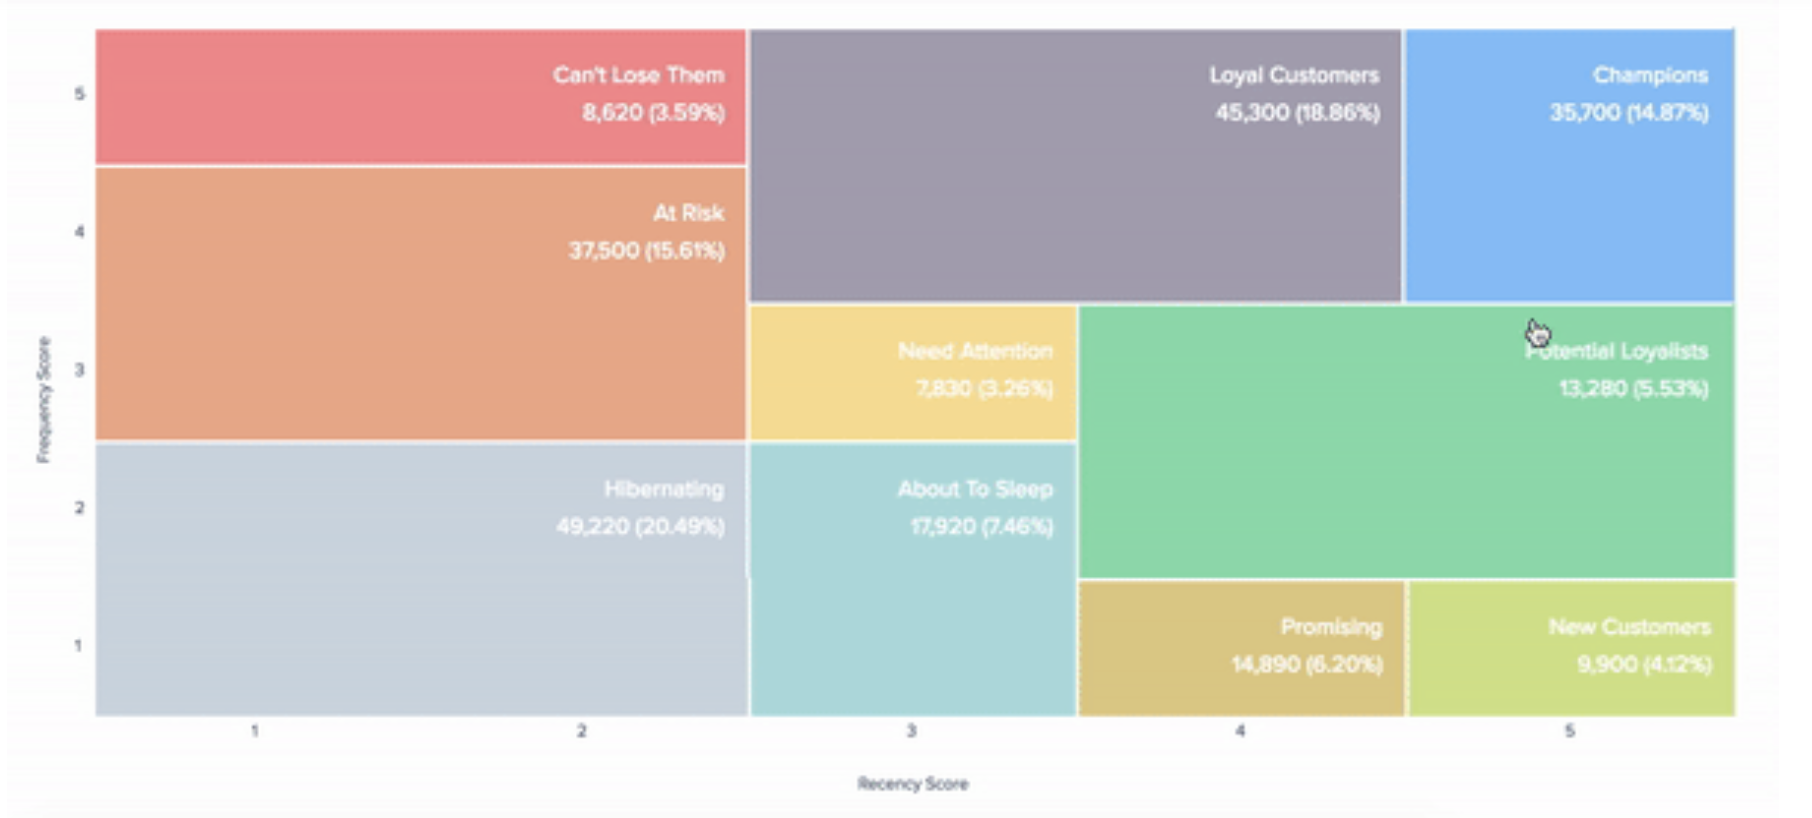

The 10 segments based on the RF scores are:
1. Hibernating: 11, 12, 21, 22
2. At Risk: 13, 14, 23, 24
3. Can't Lose: 15, 25
4. About to Sleep: 31, 32
5. Need Attention: 33
6. Loyal Customers: 34, 35, 44, 45
7. Promising: 41
8. New Customers: 51
9. Potential Loyalists: 42, 43, 52, 53
10. Champions: 54, 55

Understanding some of the segments:
    
1. `Champions` are your best customers, who bought most recently, most often, and are heavy spenders. Reward these customers. They can become early adopters for new products and will help promote your brand.

1. `Potential Loyalists` are your recent customers with average frequency and who spent a good amount. Offer membership or loyalty programs or recommend related products to upsell them and help them become your Loyalists or Champions.

1. `New Customers` are your customers who have a high overall RFM score but are not frequent shoppers. Start building relationships with these customers by providing onboarding support and special offers to increase their visits.

1. `At Risk Customers` are your customers who purchased often and spent big amounts, but haven’t purchased recently. Send them personalized reactivation campaigns to reconnect, and offer renewals and helpful products to encourage another purchase.

1. `Can’t Lose Them` are customers who used to visit and purchase quite often, but haven’t been visiting recently. Bring them back with relevant promotions, and run surveys to find out what went wrong and avoid losing them to a competitor.

Credit: https://clevertap.com/blog/rfm-analysis/

In [1130]:
# Segment customers based on their RF score
def rf_score(rfm_score):
    if rfm_score[:2] == '11' or rfm_score[:2] == '12' or rfm_score[:2] == '21' or rfm_score[:2] == '22':
        return 'Hibernating'
    elif rfm_score[:2] == '13' or rfm_score[:2] == '14' or rfm_score[:2] == '23' or rfm_score[:2] == '24':
        return 'At Risk'
    elif rfm_score[:2] == '15' or rfm_score[:2] == '25':
        return 'Cannot lose'
    elif rfm_score[:2] == '31' or rfm_score[:2] == '32':
        return 'About to sleep'
    elif rfm_score[:2] == '33':
        return 'Need attention'
    elif rfm_score[:2] == '34' or rfm_score[:2] == '35' or rfm_score[:2] == '44' or rfm_score[:2] == '45':
        return 'Loyal Customers'
    elif rfm_score[:2] == '41':
        return 'Promising'
    elif rfm_score[:2] == '51':
        return 'New Customers'
    elif rfm_score[:2] == '42' or rfm_score[:2] == '43' or rfm_score[:2] == '52' or rfm_score[:2] == '53':
        return 'Potential Loyalists'
    elif rfm_score[:2] == '54' or rfm_score[:2] == '55':
        return 'Champions'

In [1131]:
rfm_score_pdf['segment'] = rfm_score_pdf['RFM'].map(rf_score)

In [1132]:
rfm_score_pdf.head(10)

,Recency,Frequency,Monetary,re_score,freq_score,mon_score,RFM,segment
customer_id,,,,,,,,
12346,355,1.0,77183.60,1,1,5,115,Hibernating
12347,32,3639.0,4310.00,5,5,5,555,Champions
12348,105,2837.0,1797.24,2,4,4,244,At Risk
12349,48,2.0,1757.55,4,1,4,414,Promising
12350,340,3.0,334.40,1,1,2,112,Hibernating
12352,66,3782.0,2506.04,3,5,5,355,Loyal Customers
12353,234,4.0,89.00,1,1,1,111,Hibernating
12354,262,5.0,1079.40,1,1,4,114,Hibernating
12355,244,6.0,459.40,1,1,2,112,Hibernating


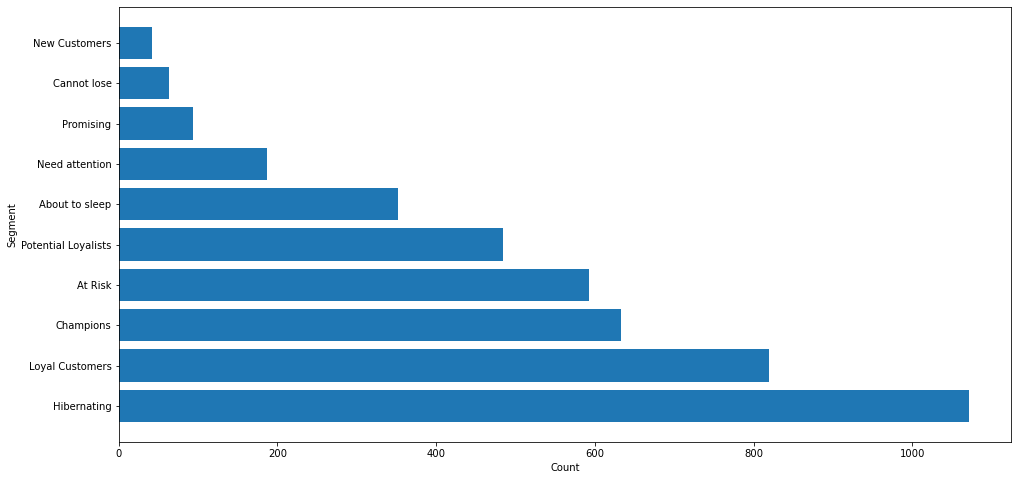

In [1133]:
# Plot the distribution of segments
segment_count = rfm_score_pdf['segment'].value_counts()
plt.figure(figsize=(16,8))
plt.barh(y = segment_count.index, width = segment_count.values)
plt.xlabel('Count')
plt.ylabel('Segment')
plt.show()

Observation: The number of hibernating customers is huge. They are customers who do not shop frequently at the store nor have they recently been at the store. Understanding the pain points of these customers could unlock more revenue for the company.

# Predicting a customer's segment

We will attempt to segment a customer using machine learning. More specifically, with KMeans clustering to investigate if the customers will be grouped similarly to the segments we have computed, or will their grouping be different.

In [1134]:
rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,122.059474,4.272015,2054.266460
std,100.012264,7.697998,8989.230441
min,30.000000,1.000000,3.750000
25%,47.000000,1.000000,307.415000
50%,80.000000,2.000000,674.485000
75%,171.750000,5.000000,1661.740000
max,403.000000,209.000000,280206.020000


## Standardise the values of RFM

In [1158]:
# Standardise the values of R, F and M
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm.copy())
rfm_scaled

array([[ 2.32938811e+00, -4.25096503e-01,  8.35866818e+00],
       [-9.00588115e-01,  3.54416797e-01,  2.50966264e-01],
       [-1.70593488e-01, -3.53398530e-02, -2.85960063e-02],
       ...,
       [-8.50588483e-01, -2.95177619e-01, -2.08742313e-01],
       [-8.90588188e-01,  1.52368675e+00,  4.51854273e-03],
       [-5.00591059e-01, -1.65258736e-01, -2.41412739e-02]])

In [1159]:
rfm_scaled_pdf = pd.DataFrame(rfm_scaled, index=rfm.index, columns=["recency_scaled", "frequency_scaled", "monetary_scaled"])
rfm_scaled_pdf.head(5)

,recency_scaled,frequency_scaled,monetary_scaled
customer_id,,,
12346,2.329388,-0.425097,8.358668
12347,-0.900588,0.354417,0.250966
12348,-0.170593,-0.035340,-0.028596
12349,-0.740589,-0.425097,-0.033012
12350,2.179389,-0.425097,-0.191347


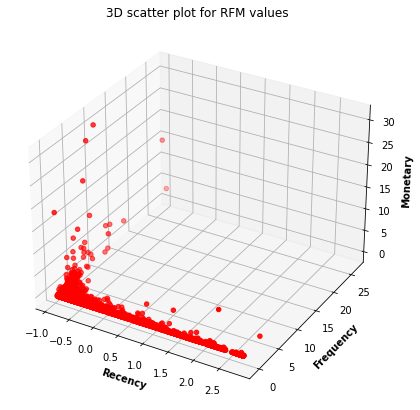

In [1160]:
# Plot rfm_scaled_pdf on a 3-D plot

r = rfm_scaled_pdf["recency_scaled"]
f = rfm_scaled_pdf["frequency_scaled"]
m = rfm_scaled_pdf["monetary_scaled"]

fig = plt.figure(figsize=(15,7))
ax = plt.axes(projection="3d")

ax.scatter3D(r, f, m, color="red")

plt.title("3D scatter plot for RFM values")
ax.set_xlabel('Recency', fontweight ='bold')
ax.set_ylabel('Frequency', fontweight ='bold')
ax.set_zlabel('Monetary', fontweight ='bold')

plt.show()

## KMeans clustering

### KMeans with 10 clusters

In [1161]:
# Train a K-Means model with 10 clusters
rfm_10means_model = KMeans(n_clusters=10)
rfm_10means_model.fit(rfm_scaled_pdf)

KMeans(n_clusters=10)

In [1162]:
# Cluster values for the input
rfm_10means_pred = rfm_10means_model.predict(rfm_scaled_pdf)
rfm_10means_pred

array([9, 6, 3, ..., 0, 6, 0], dtype=int32)

In [1163]:
# Cluster centers
centroids_10 = rfm_10means_model.cluster_centers_
centroids_10

array([[-6.75406674e-01, -1.47106689e-01, -1.06098843e-01],
       [ 2.19072671e+00, -3.89237787e-01, -1.84460631e-01],
       [-8.98088133e-01,  5.32381408e+00,  2.48845740e+01],
       [-2.18653014e-02, -2.64456469e-01, -1.32027127e-01],
       [-8.13463756e-01,  3.16391265e+00,  1.37853407e+00],
       [-9.15588004e-01,  2.60783557e+01,  9.64800335e+00],
       [-7.33656828e-01,  8.92158759e-01,  2.69330842e-01],
       [ 1.05754562e+00, -3.20330265e-01, -1.50263336e-01],
       [-9.06588071e-01,  1.22030189e+01,  3.86419168e+00],
       [-5.83667371e-01,  3.86222664e+00,  7.98512349e+00]])

In [1164]:
rfm_scaled_pdf["label"] = rfm_10means_pred

In [1165]:
rfm_scaled_pdf.head(5)

,recency_scaled,frequency_scaled,monetary_scaled,label
customer_id,,,,
12346,2.329388,-0.425097,8.358668,9
12347,-0.900588,0.354417,0.250966,6
12348,-0.170593,-0.035340,-0.028596,3
12349,-0.740589,-0.425097,-0.033012,0
12350,2.179389,-0.425097,-0.191347,1


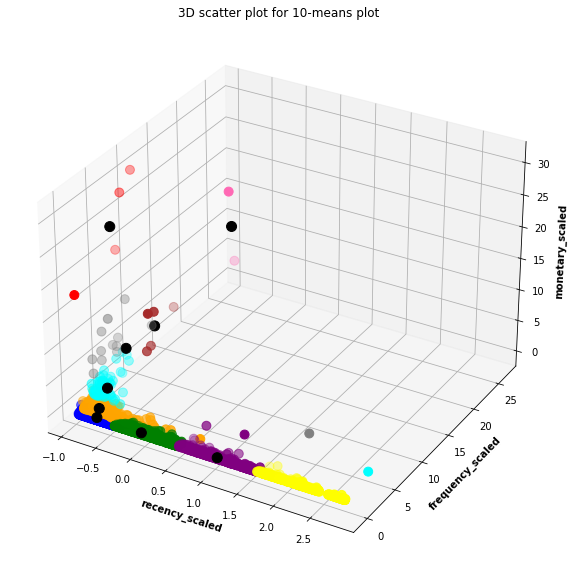

In [1166]:
# Visualising the centroids of the clusters amongst the datas
x = rfm_scaled_pdf.iloc[:,[0,1,2]].values

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

a = np.array(rfm_10means_pred==0)
b = np.array(rfm_10means_pred==1)
c = np.array(rfm_10means_pred==2)
d = np.array(rfm_10means_pred==3)
e = np.array(rfm_10means_pred==4)
f = np.array(rfm_10means_pred==5)
g = np.array(rfm_10means_pred==6)
h = np.array(rfm_10means_pred==7)
i = np.array(rfm_10means_pred==8)
j = np.array(rfm_10means_pred==9)


ax.scatter(centroids_10[:,0],centroids_10[:,1],centroids_10[:,2],c="black",s=100,label="Centriods",alpha=1)
ax.scatter(x[a,0],x[a,1],x[a,2],c="blue",s=80,label="0")
ax.scatter(x[b,0],x[b,1],x[b,2],c="yellow",s=80,label="1")
ax.scatter(x[c,0],x[c,1],x[c,2],c="red",s=80,label="2")
ax.scatter(x[d,0],x[d,1],x[d,2],c="green",s=80,label="3")
ax.scatter(x[e,0],x[e,1],x[e,2],c="cyan",s=80,label="4")
ax.scatter(x[f,0],x[f,1],x[f,2],c="hotpink",s=80,label="5")
ax.scatter(x[g,0],x[g,1],x[g,2],c="orange",s=80,label="6")
ax.scatter(x[h,0],x[h,1],x[h,2],c="purple",s=80,label="7")
ax.scatter(x[i,0],x[i,1],x[i,2],c="brown",s=80,label="8")
ax.scatter(x[j,0],x[j,1],x[j,2],c="gray",s=80,label="9")

plt.title("3D scatter plot for 10-means plot")
ax.set_xlabel('recency_scaled', fontweight ='bold')
ax.set_ylabel('frequency_scaled', fontweight ='bold')
ax.set_zlabel('monetary_scaled', fontweight ='bold')

plt.show()


### Optimized number of clusters

In [1167]:
# Caluclate the wcss for a range of clusters to find the optimal value of k
wcss = []

for i in range(1, 15):
    kmeans_model = KMeans(n_clusters=i)
    kmeans_model.fit(rfm_scaled_pdf)
    
    wcss.append(kmeans_model.inertia_)

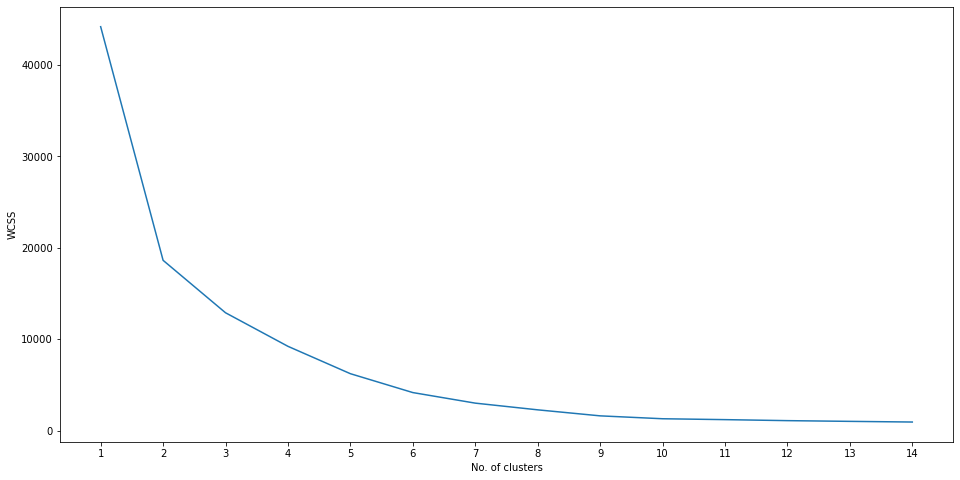

In [1168]:
plt.figure(figsize=(16,8))
plt.plot(range(1,15), wcss)
plt.xticks(range(1,15))
plt.xlabel("No. of clusters")
plt.ylabel("WCSS")
plt.show()

By the elbow method, the optimal number of clusters for the iris problem is 5. Having more than 5 clusters only reduces the value of WCSSS minimally.

### KMeans with 5 clusters

In [1169]:
# Train a K-Means model with 5 clusters
rfm_5means_model = KMeans(n_clusters=5)
rfm_5means_model.fit(rfm_scaled_pdf)

KMeans(n_clusters=5)

In [1170]:
# Cluster values for the input
rfm_5means_pred = rfm_5means_model.predict(rfm_scaled_pdf)
rfm_5means_pred

array([1, 1, 2, ..., 0, 1, 0], dtype=int32)

In [1171]:
# Cluster centers
centroids_5 = rfm_5means_model.cluster_centers_
centroids_5

array([[-6.78625056e-01, -1.44764698e-01, -1.05431723e-01,
        -3.10862447e-15],
       [ 2.46414512e-01,  2.28213306e-01,  5.21095598e-02,
         6.55258303e+00],
       [-8.98024999e-02, -1.85467308e-02, -2.64486279e-02,
         3.07615230e+00],
       [-8.65972985e-01,  8.07459659e+00,  9.32891329e+00,
         6.65384615e+00],
       [ 2.18711068e+00, -3.89464741e-01, -1.84609013e-01,
         1.00000000e+00]])

In [1172]:
rfm_scaled_pdf["label"] = rfm_5means_pred
rfm_scaled_pdf.head(5)

,recency_scaled,frequency_scaled,monetary_scaled,label
customer_id,,,,
12346,2.329388,-0.425097,8.358668,1
12347,-0.900588,0.354417,0.250966,1
12348,-0.170593,-0.035340,-0.028596,2
12349,-0.740589,-0.425097,-0.033012,0
12350,2.179389,-0.425097,-0.191347,4


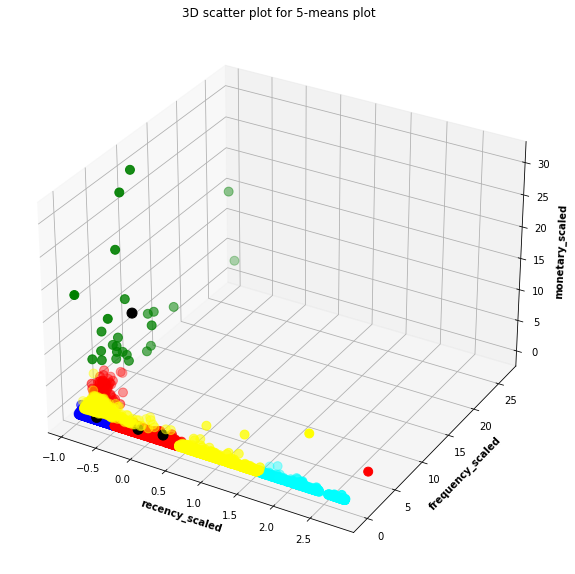

In [1173]:
# Visualising the centroids of the clusters amongst the datas
x = rfm_scaled_pdf.iloc[:,[0,1,2]].values

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

a = np.array(rfm_5means_pred==0)
b = np.array(rfm_5means_pred==1)
c = np.array(rfm_5means_pred==2)
d = np.array(rfm_5means_pred==3)
e = np.array(rfm_5means_pred==4)


ax.scatter(centroids_5[:,0],centroids_5[:,1],centroids_5[:,2],c="black",s=100,label="Centriods",alpha=1)
ax.scatter(x[a,0],x[a,1],x[a,2],c="blue",s=80,label="0")
ax.scatter(x[b,0],x[b,1],x[b,2],c="yellow",s=80,label="1")
ax.scatter(x[c,0],x[c,1],x[c,2],c="red",s=80,label="2")
ax.scatter(x[d,0],x[d,1],x[d,2],c="green",s=80,label="3")
ax.scatter(x[e,0],x[e,1],x[e,2],c="cyan",s=80,label="4")

plt.title("3D scatter plot for 5-means plot")
ax.set_xlabel('recency_scaled', fontweight ='bold')
ax.set_ylabel('frequency_scaled', fontweight ='bold')
ax.set_zlabel('monetary_scaled', fontweight ='bold')

plt.show()

### KMeans cluster VS RFM segment

In [1184]:
kmeans_and_rfm_pdf = pd.merge(rfm_score_pdf, rfm_scaled_pdf, on="customer_id")
kmeans_and_rfm_pdf

,Recency,Frequency,Monetary,re_score,freq_score,mon_score,RFM,segment,recency_scaled,frequency_scaled,monetary_scaled,label
customer_id,,,,,,,,,,,,
12346,355,1.0,77183.60,1,1,5,115,Hibernating,2.329388,-0.425097,8.358668,1
12347,32,3639.0,4310.00,5,5,5,555,Champions,-0.900588,0.354417,0.250966,1
12348,105,2837.0,1797.24,2,4,4,244,At Risk,-0.170593,-0.035340,-0.028596,2
12349,48,2.0,1757.55,4,1,4,414,Promising,-0.740589,-0.425097,-0.033012,0
12350,340,3.0,334.40,1,1,2,112,Hibernating,2.179389,-0.425097,-0.191347,4
...,...,...,...,...,...,...,...,...,...,...,...,...
18280,307,1492.0,180.60,1,2,1,121,Hibernating,1.849392,-0.425097,-0.208459,4
18281,210,1493.0,80.82,1,2,1,121,Hibernating,0.879399,-0.425097,-0.219560,1
18282,37,2328.0,178.05,5,3,1,531,Potential Loyalists,-0.850588,-0.295178,-0.208742,0


In [1193]:
# Retrieve the segments associated to the respective labels.
for label in [0, 1, 2, 3, 4]:
    segments = kmeans_and_rfm_pdf[kmeans_and_rfm_pdf["label"]==label]["segment"].value_counts()
    print(f"label: {label}")
    print(segments)
    print("\n")

label: 0
Loyal Customers        551
Potential Loyalists    483
Champions              287
About to sleep         189
Need attention         110
Promising               94
New Customers           42
Name: segment, dtype: int64


label: 1
Hibernating        358
Champions          259
At Risk            223
Loyal Customers    217
Cannot lose         27
Name: segment, dtype: int64


label: 2
At Risk            315
Hibernating        298
About to sleep     163
Need attention      77
Champions           65
Loyal Customers     48
Cannot lose         32
Name: segment, dtype: int64


label: 3
Champions              22
Loyal Customers         3
Potential Loyalists     1
Name: segment, dtype: int64


label: 4
Hibernating    415
At Risk         55
Cannot lose      4
Name: segment, dtype: int64




Observation: Each cluster identified through the k-means algorithm is associated to a few segments generated by the RFM-score. Some seem to be more straightforward, some a little less.

The algorithm seems to be able to identify the group of customers who are on either extreme ends - very loyal customers vs customers who have little interest in the store (see clusters 3 and 4).

On the other hand, in clusters 0, 1, 2, we see a mixed of segments within each cluster. If we zoom in to clusters 0 and 2, we will notice that there is a 'theme' of segments that form the majority. In cluster 0, the majority is made up of relatively loyal customers but yet, they are grouped with customers who are 'About to sleep' and 'Need attention'. This suggests that the algorithm could have identified potential customers who could turn out to be loyal ones. A similar observation can be derived for cluster 2.

Having this additional information about customers could augment the information from the RFM-score to better segment customers in order to provide better reccommendations to them or help the company in targetting the right campaigns to the right customers.

# The End